# Prioritized Experience Replay

Baseado no paper [Prioritized Experience Replay, Schaul et al, 2015.](https://deepmind.com/research/publications/prioritized-experience-replay)

## Motivação

Conforme já vimos, a técnica de [experience replay](https://github.com/GrupoTuring/Aprendizado-por-Reforco/tree/per/Aprendizado%20por%20Refor%C3%A7o%20Profundo/Deep%20Q-Learning/Experience%20Replay) é muito importante para garantir a convergência do agente de [DQN](https://github.com/GrupoTuring/Aprendizado-por-Reforco/tree/per/Aprendizado%20por%20Refor%C3%A7o%20Profundo/Deep%20Q-Learning/Deep%20Q-Network). Por um lado, experience replay permite que o agente relembre ao longo do tempo suas experiências antigas, de forma análoga ao epochs utilizados em outras aplicações. Por outro lado, mais matemático, essa prática diminui a correlação entre as observações passadas à rede neural, o que tende a melhorar o treinamento.

Essa noção de que experience replay ajuda o agente a relembrar o passado encontra uma analogia no comportamento animal:

> Numerous neuroscience studies have identified evidence of experience replay in the hippocampus of rodents, suggesting that sequences of **prior experience are replayed**, either during awake resting or sleep. Sequences associated with rewards appear to be replayed more frequently (Atherton et al., 2015; Ólafsdóttir et al., 2015; Foster & Wilson, 2006). **Experiences with high magnitude TD error also appear to be replayed more often** (Singer & Frank, 2009; McNamara et al., 2014).
>
> Prioritized Experience Replay, Schaul et al, 2015. [1](https://deepmind.com/research/publications/prioritized-experience-replay)

## Teoria

### Prioritized Experience Replay

Conforme destacam os pesquisadores em [1](https://deepmind.com/research/publications/prioritized-experience-replay), uma estratégia melhor que simplesmente escolher experiências aleatórias é escolher, de alguma forma, as experiências que mais contribuem para o aprendizado do agente. Inicialmente, consideraremos o ambiente Blind Cliffwalk, abaixo, em que as setas vermelhas são terminais e a seta verde é a única ação com recompensa não-nula. Nesse caso, a transição mais relevante, destacada em verde, provavelmente será vista muito pouco pelo agente.

No gráfico da direita, vemos a comparação entre um agente que escolhe experiências aleatóriamente (_uniform_) e outro que utiliza um oráculo (_oracle_), que sempre sabe qual a ação que acarreta na maior redução do custo. O eixo horizontal indica o tamanho do replay buffer, enquanto o eixo vertical indica o número de updates necessários para treinar o agente. Claramente, o agente com o oráculo aprende mais rápido.

![blind cliffwalk](imgs/blind_cliffwalk.png)

Como não temos um oráculo à disposição, precisamos de alguma métrica que nos indique o quão surpreendente uma dada experiência é. Uma boa alternativa é a função de custo (ou o TD-error, no caso de Q-Learning tabular), visto que ela está associada à diferença entre a estimativa atual do agente de _Q_(_s_,_a_) e a estimativa de bootstrap.

O gráfico abaixo, também de [1], mostra que o uso do erro TD é uma aproximação razoável. A linha preta, que indica o método básico de experience replay, é sempre a de aprendizado mais lento. A linha vermelha (_greedy_) corresponde ao erro TD e é claramente melhor do que o método básico, mas pior do que o oráculo (azul).

![comparação entre formas de experience replay](imgs/per_comparison.png)

### Stochastic Prioritized Experience Replay

A escolha sempre da experiência de maior prioridade (gulosa) é muito sucetível a ruído e incentiva pouco a exploração. Por isso, em geral, amostramos aleatoriamente as experiências, mas dando maior probabilidade para as experiências de maior prioridade:
$$P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha} \propto p_i^\alpha,$$
onde $\alpha$ determina a quantidade de priorização utilizada. Quando $\alpha=0$, tem-se o caso uniforme.

Em geral, a prioridade é dada por $p_i = \left|J_i\right| + \epsilon$, onde $\epsilon$ é uma constante positiva pequena. O propósito da adição de $\epsilon$ ao custo é de garantir que todas as experiências tenham alguma probabilidade de serem revisitadas, mesmo se atingirem erro zero.

### Redução do Viés

Em DQN, utilizamos uma função de custo, e.g. o MSE:

\begin{align*}
    J_{\mathrm{ideal}}       &= E\left[{\left(Q(s,a) - Q_{\theta}(s,a)\right)}^2\right] \\
    J_{\mathrm{bootstrap},i} &= {\left(Q_{\mathrm{bootstrap}}(s_i,a_i) - Q_{\theta}(s_i,a_i)\right)}^2 \\
\\
  \theta       &\leftarrow \theta + \eta \Delta\theta \\
  \Delta\theta &= -\frac{1}{2}\nabla_{\theta} J_{\mathrm{bootstrap}}\\
               &= \left(Q_{\mathrm{bootstrap}}(s_i,a_i) - Q_{\theta}(s_i,a_i)\right) \cdot \nabla_{\theta} Q_{\theta}(s_i,a_i) \\
               &= \delta_i \cdot \nabla_{\theta} Q_{\theta}(s_i,a_i).
\end{align*}

A aproximação de bootstrap, de que $J_{\mathrm{bootstrap}} \approx J_{\mathrm{ideal}}$, é não enviesada quando as experiências utilizadas para calcular $Q_{\mathrm{bootstrap}}$ tem a mesma distribuição que na esperança. Em outras palavras, quando as ditribuições são as mesmas, espera-se que erros positivos e negativos nessa aproximação se "anulem" com o tempo.

O uso de priorização muda a distribuição das experiências, de forma que essa aproximação se torna enviesada. Uma técnica chamada _importance sampling_ pode ser utilizada para corrigir esse viés, multiplicando a atualização dos pesos por um coeficiente $w_i$:

$\tilde w_i = \left(\frac1N \cdot \frac{1}{P(i)}\right)^\beta,
  \quad
  w_i = \frac{\tilde w_i}{\max_i \tilde w_i}
  \qquad
  \Delta\theta = w_i \cdot \delta_i \cdot \nabla_{\theta} Q_{\theta}(s_i,a_i),$

onde $\beta=1$ corresponde ao caso não-enviesado (note que as probabilidades ficam uniformes). Analisando as equações, observa-se que as experiências de maior prioridade (que são amostradas mais frequentemente) são dadas menor peso na atualização de $\theta$, reduzindo o viés. Essa redução de $w_i$ quando o erro é alto também ajuda a mitigar a probabilidade de overshooting.

Em relação ao treinamento do agente, observa-se que a priorização é mais importante no início do treinamento, enquanto o não-enviesamento é mais importante no final do treinamento, quando o agente já está mais estável. Por isso, é comum aumentar o $\beta$ linearmente de seu valor inicial $\beta=\beta_0$ até o valor final $\beta=1$.

## Importações

Usaremos, como sempre, numpy para lidarmos com arrays e operações matemáticas, e torch para lidar com tensores e aprendizado profundo.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Memória com Amostras Prioritárias

In [2]:
class PrioritizedExperienceReplay:
    """Classe de um Experience Replay Buffer para DQNs,com priority sampling."""
    def __init__(self, sdim, maxlen, alpha, offset):
        """Cria um Replay Buffer.

        Parâmetros
        ----------
        sdim: int
            Tamanho do espaço de observação.
        maxlen: int
            Tamanho máximo do Replay Buffer.
        alpha: float no intervalo (0,1)
            Quanto a priorização é relevante.
        offset: float < 1
            Garante que todas as experiências podem ser revisitadas.
        """ 
        self._maxlen = maxlen
        self._alpha  = alpha
        self._offset = offset
        self._memory = {
            "states":   np.zeros((maxlen, *sdim), dtype=np.float32),
            "actions":  np.zeros((maxlen), dtype=np.float32),
            "rewards":  np.zeros((maxlen), dtype=np.float32),
            "nstates":  np.zeros((maxlen, *sdim), dtype=np.float32),
            "dones":    np.zeros((maxlen), dtype=np.float32),
            "priority": np.zeros((maxlen), dtype=np.float32)
        }
        self._index = 0
        self._len = 0

    def _iindex(self):
        """Incrementa o índice de acordo o maxlen. 
        Se o índice for maior que o maxlen, ele 
        começa novamente."""
        self._index = (self._index+1) % self._maxlen

    def push(self, s, a, r, s2, d):
        """Adiciona uma experiência ao Replay Buffer.

        Parâmetros
        ----------
        s: np.array
            Estado da transição.
        a: int
            Ação tomada.
        r: float
            Recompensa recebida.
        s2: np.array
            Estado seguinte.
        d: int
            Flag indicando se o episódio acabou.
        """
        if len(self) > 0: 
            mx = np.max(self._memory["priority"][:len(self)])
        else:
            mx = 1
        if len(self) < self._maxlen:
            self._len += 1
        self._memory["states"][self._index]  = s
        self._memory["actions"][self._index] = a
        self._memory["rewards"][self._index] = r
        self._memory["nstates"][self._index] = s2
        self._memory["dones"][self._index]   = d
        self._memory["priority"][self._index] = mx
        self._iindex()

    def sample(self, batch):
        """Retorna um batch de experiências.
        
        Parâmetros
        ----------
        batch_size: int
            Tamanho do batch de experiências.

        Retorna
        -------
        tupla de:
        states: np.array
            Batch de estados.
        actions: np.array
            Batch de ações.
        rewards: np.array
            Batch de recompensas.
        next_states: np.array
            Batch de estados seguintes.
        dones: np.array
            Batch de flags indicando se o episódio acabou.
        priority: np.array
            Batch das prioridades.
        indexes: int
            índice aleatório com base nas prioridades.
        """
        n = len(self)
        indexes = random.choices(range(n),
                                 weights = self._memory["priority"][:n],
                                 k = batch)
        to_return = (
            self._memory["states"  ][indexes],
            self._memory["actions" ][indexes],
            self._memory["rewards" ][indexes],
            self._memory["nstates" ][indexes],
            self._memory["dones"   ][indexes],
            self._memory["priority"][indexes]/self._memory["priority"].sum(),
            indexes)
        return to_return

    def update_priority(self, index, newp):
        q = (newp.type(torch.float64) + self._offset)**self._alpha
        self._memory["priority"][index] = q.detach().cpu().numpy().flatten()

    def __len__(self):
        return self._len

## Rede Neural

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim[0], 64), 
            nn.ReLU(),
            nn.Linear(64, 64), 
            nn.ReLU(), 
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
        return self.layers(x)

## O Agente

Pelo nosso agente ainda utilizar principalmente [DQN](https://github.com/GrupoTuring/Aprendizado-por-Reforco/tree/per/Aprendizado%20por%20Refor%C3%A7o%20Profundo/Deep%20Q-Learning/Deep%20Q-Network) muitos de seus parâmetros são análogos ao agente DQN.

Os parâmetros exclusivos do Prioritized Experience Replay são:
- ```alpha```: o quanto a priorização é relevante
- ```loss_param```: correção de viés nas experiências
- ```lp_increase```: o quanto a correção vai deixando de ser relevante


In [4]:
class Agent:
    """
    Uma classe que cria um agente DQN que utiliza Experience Replay com
    priority sample como memória.
    """
    def __init__(self,
                 env,
                 hyperparameters):

        self._alpha       = hyperparameters["a"]
        self._loss_param  = hyperparameters["b"]
        self._lp_increase = hyperparameters["beta_decay"]
        self._lr          = hyperparameters["lr"]
        self._batch       = hyperparameters["batch"]
        self._epsilon     = hyperparameters["e0"]
        self._epsilon_min = hyperparameters["ef"]
        self._gamma       = hyperparameters["gamma"]
        self._steps       = 0
        
        self.device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._memory       = PrioritizedExperienceReplay(env.observation_space.shape, 100000, self._alpha, 0.0001)
        self._action_space = env.action_space

        self._decay = self._epsilon_min**(1/hyperparameters["decay"])

        self.dqn        = Network(env.observation_space.shape, env.action_space.n).to(self.device)

        self._opt       = optim.Adam(self.dqn.parameters(), lr=self._lr)

    def apply_decay(self):
        self._epsilon = max(self._epsilon*self._decay, self._epsilon_min)

    def act(self, state):
        if random.random() < self._epsilon:
            return self._action_space.sample()

        with torch.no_grad():
            state = torch.FloatTensor(state).to(self.device,non_blocking=True)
            action = self.dqn.forward(state).argmax(dim=-1)
            action = action.cpu().numpy()

            return action

    def save_on_memory(self, s, a, r, s2, d):
        self._memory.push(s, a, r, s2, d)

    def train(self):
        self._steps += 1
        if len(self._memory) < self._batch:
            return -float("inf")

        s, a, r, s2, d, p, i = self._memory.sample(self._batch)

        s = torch.as_tensor(s).to(self.device, non_blocking=True)
        a = torch.as_tensor(a).to(self.device, non_blocking=True).unsqueeze(-1)
        r = torch.as_tensor(r).to(self.device, non_blocking=True).unsqueeze(-1)
        s2 = torch.as_tensor(s2).to(self.device, non_blocking=True)
        d = torch.as_tensor(d).to(self.device, non_blocking=True).unsqueeze(-1)

        q_eval = self.dqn.forward(s).gather(-1, a.long())

        with torch.no_grad():
            q_next = self.dqn.forward(s2).max(dim=-1, keepdim=True)[0]
            target = (r + self._gamma*q_next*(1 - d)).to(self.device)
            N      = len(self._memory)
            w      = (N * p)**(-self._loss_param)
            w      = w/w.max()
            self._loss_param *= 1 + self._lp_increase if self._loss_param < 1 else 1

        loss = F.mse_loss(q_eval, target, reduction="none")
        self._memory.update_priority(i, torch.abs(loss))


        w = torch.as_tensor(w).to(self.device).unsqueeze(-1)
        weighted_loss = loss * w
        final_loss    = torch.mean(weighted_loss)
        self._opt.zero_grad()
        final_loss.backward()
        for param in self.dqn.parameters():
            param.grad.data.clamp_(-100, 100)
        self._opt.step()

        return final_loss

    @property
    def epsilon(self):
        return self._epsilon

    @property
    def beta(self):
        return self._loss_param

    @property
    def memory(self):
        return self._memory


## Hiperparâmetros e Loop Principal

In [5]:
hparams = {
    "a":0.6,
    "b":0.4,
    "beta_decay": 2.5e-5,
    "lr":1e-3,
    "gamma":0.999,
    "e0":1,
    "ef":0.01,
    "decay":150,
    "batch":64,
}

env = gym.make("CartPole-v1")
agent = Agent(env, hparams)

episodes = 400
history = []
tts = 0
for i in range(1, episodes + 1):
    steps = 0
    rewards = 0
    total_loss = 0
    done = False
    state = env.reset()
    while not done:
        action = agent.act(state)
        sstate, reward, done, _ = env.step(action)
        agent.save_on_memory(state, action, reward, sstate, done)
        loss = agent.train()
        state = sstate
        rewards += reward
        steps += 1
        total_loss += loss
    # if i%100 == 0:
    #     save(agent.dqn.state_dict(), f"{str(i)}.pth")
    print(f"\r episode [{i:04d}] - rewards [{rewards}] - duration [{steps:04d}] - epsilon [{100*agent.epsilon:.2f}%] - beta [{agent.beta:.2f}]", end="")
    history.append(rewards)
    agent.apply_decay()

 episode [0400] - rewards [316.0] - duration [0316] - epsilon [1.00%] - beta [1.00]

## Curva de Aprendizado

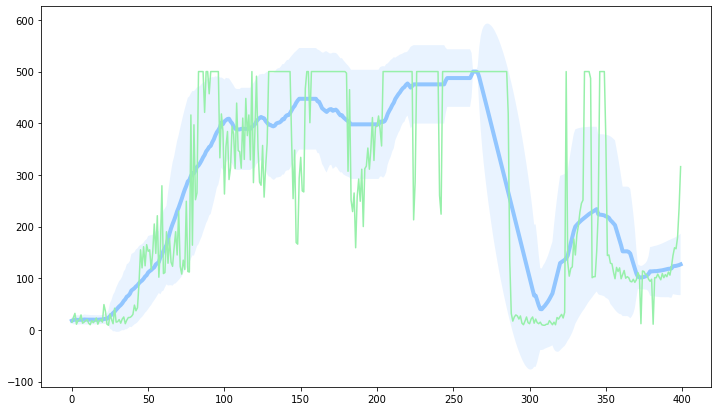

In [6]:
means = [0]*episodes
high = [0]*episodes
low  = [0]*episodes
for i in range(episodes):
    start = max(0, i - 20)
    end = min(episodes, i + 21)
    slice = history[ start : end ]
    mean = sum(slice)/(end - start)
    std = np.std(slice)
    means[i] = mean
    high[i] = mean + std
    low[i] = mean - std

plt.figure(figsize=(12,7))
with plt.style.context("seaborn-pastel"):
    x = [k for k in range(episodes)]
    plt.fill_between(x, low, high, alpha=0.2)
    plt.plot(x, means, linewidth=4)
    plt.plot(x, history)
    plt.show()